# [LG 에너지 솔루션]
## DX Expert 양성과정 WEEK 2
## Convolutional Neural Network 2 - (1)

## 강의 복습
Convolutional Neural Network - Part 2

* ADENDA 02 Popular CNN Structures

* ADENDA 03 CAM & Grad-CAM

## 실습 요약
1. 본 실습에서는 사전학습된 CNN 모델을 활용하여 분류 문제를 풀이합니다.
2. 학습된 모델을 활용하여 평가를 진행합니다.
3. 학습된 모델에 GradCAM을 적용하여 예측에 가장 큰 영향을 미친 부분을 탐지해냅니다.


---

### STEP 0. 환경 구축하기
* 필요한 Library 들을 import 합니다

In [1]:
# Data Analysis
import os
import random
import pandas as pd
import numpy as np

import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
%matplotlib inline
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Check torch version & device
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.11.0+cu113].
device:[cuda:0].


In [2]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42)

---

### STEP 1. 데이터 준비하기
금일 실습에서는 **casting product image data for quality inspection** 이미지 데이터를 활용합니다. 
* casting은 몰드에 liquid material을 부어 원하는 모양의 제품을 만들어내는 과정으로, 해당 과정에서 일정한 제품 shape를 유지하는것이 중요함 
* 정밀 검사 과정에서 생산 제품에 대해 Ok / Defect 결정을 내릴 수 있음
* 데이터셋 출처 
    : https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

casting_data  
├───test  
│   ├───def_front  
│   └───ok_front  
└───train  
    ├───def_front  
    └───ok_front  

In [3]:
# github에서 데이터 불러오기
!git clone https://github.com/yukyunglee/LG_ES_CNN_2

Cloning into 'LG_ES_CNN_2'...
remote: Enumerating objects: 14618, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 14618 (delta 6), reused 22 (delta 6), pack-reused 14596
Receiving objects: 100% (14618/14618), 169.46 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [4]:
! unzip ./LG_ES_CNN_2/data/casting_data.zip -d ./LG_ES_CNN_2/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./LG_ES_CNN_2/data/casting_data/train/def_front/cast_def_0_5881.jpeg  
  inflating: ./LG_ES_CNN_2/data/__MACOSX/casting_data/train/def_front/._cast_def_0_5881.jpeg  
  inflating: ./LG_ES_CNN_2/data/casting_data/train/def_front/cast_def_0_4639.jpeg  
  inflating: ./LG_ES_CNN_2/data/__MACOSX/casting_data/train/def_front/._cast_def_0_4639.jpeg  
  inflating: ./LG_ES_CNN_2/data/casting_data/train/def_front/cast_def_0_958.jpeg  
  inflating: ./LG_ES_CNN_2/data/__MACOSX/casting_data/train/def_front/._cast_def_0_958.jpeg  
  inflating: ./LG_ES_CNN_2/data/casting_data/train/def_front/cast_def_0_7015.jpeg  
  inflating: ./LG_ES_CNN_2/data/__MACOSX/casting_data/train/def_front/._cast_def_0_7015.jpeg  
  inflating: ./LG_ES_CNN_2/data/casting_data/train/def_front/cast_def_0_5028.jpeg  
  inflating: ./LG_ES_CNN_2/data/__MACOSX/casting_data/train/def_front/._cast_def_0_5028.jpeg  
  inflating: ./LG_ES_CNN_2/data/casting_data/train/def_front/cast_def_0

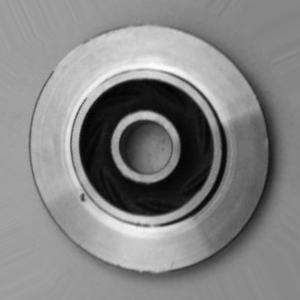

In [5]:
# defect 이미지 불러오기
img_path = os.path.join('./LG_ES_CNN_2/data/casting_data', "train/def_front/cast_def_0_0.jpeg")
def_img = Image.open(img_path)
def_img

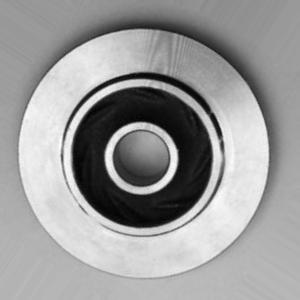

In [7]:
# ok 이미지 불러오기
img_path = os.path.join('./LG_ES_CNN_2/data/casting_data', "train/ok_front/cast_ok_0_1.jpeg")
def_img = Image.open(img_path)
def_img

### STEP 2. 전처리 진행 (Preprocessing)

In [ ]:
# 데이터 전처리
# 이미지 형태의 데이터를 숫자값으로 변경하고, 적절한 Normalization을 진행합니다.

transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### STEP 3. Pytorch Dataset 정의하기
* 딥러닝 프레임워크를 활용하여 학습하기위해서는 물리적인 데이터셋을 학습 가능한 형태로 바꾸어주어야 합니다
* Pytorch에서는 Dataset이라는 class를 상속받아 해당 값을 정의내릴 수 있습니다

In [ ]:
class CastingDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = path
        # 이미지의 경로를 맞추어 학습데이터/평가데이터를 불러올 수 있도록 준비합니다
        if train:
            self.def_path = path + "/train/def_front"
            self.ok_path = path + "/train/ok_front"
        else:
            self.def_path = path + "/test/def_front"
            self.ok_path = path + "/test/ok_front"
        # 해당 경로에 있는 모든 데이터를 가져오며 jpeg 확장자인 모든 파일을 사용합니다
        # glob라는 라이브러리를 통해 모든 이미지를 list형태로 불러올 수 있게됩니다
        self.def_img_list = glob.glob(self.def_path + "/*.jpeg")
        self.ok_img_list = glob.glob(self.ok_path + "/*.jpeg")

        # 미리 선언해두었던 전처리 프로세스를 불러옵니다
        self.transform = transform
        # defect, ok 이미지를 모두 합쳐 전체 이미지 데이터를 구성합니다
        self.img_list = self.def_img_list + self.ok_img_list

        # 이미지별 학습 라벨(label)을 부착합니다
        # defect : 0 / ok : 1
        self.class_list = [0] * len(self.def_img_list) + [1] * len(self.ok_img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        label = self.class_list[idx]
        img = Image.open(img_path)

        # 선언되었던 전처리를 이미지에 적용하는 과정
        if self.transform is not None:
            img = self.transform(img)

        # CastingDataset은 image와 label을 하나의 세트로 리턴하게 됩니다
        return img, label

### STEP 4. 모델 정의 및 학습 준비하기
* pretrained CNN 모델인 ResNet을 활용하여 분류 문제 풀이를 준비합니다
* 미리 학습된 가중치를 load하는 방법과 학습 모델을 수정하는 방법을 숙지하면 됩니다

In [ ]:
# Parameter setting
NUM_CLASS = 2

BATCH = 50
EPOCH = 10
LR = 0.0001

LOGGING = 10


In [ ]:
# Dataset을 정의
train_dataset = CastingDataset(
    path="./LG_ES_CNN_2/data/casting_data", train=True, transform=transformations
)
test_dataset = CastingDataset(
    path="./LG_ES_CNN_2/data/casting_data", train=False, transform=transformations
)
# mini-batch로 나누어 학습가능한 형태로 변환
# Dataloader라 부름
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH, shuffle=True, drop_last=False
)
test_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH, shuffle=True, drop_last=False
)


In [ ]:
# # googlenet (inception v3)
# inception = torchvision.models.inception_v3(pretrained=True)
# inception.AuxLogits.fc = nn.Linear(768, num_classes)
# inception.fc = nn.Linear(2048, num_classes)

# # densenet
# densenet = torchvision.models.densenet121(pretrained=True)
# densenet.classifier = nn.Linear(1024, num_classes)

In [ ]:
# 모델 정의하기 

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# 데이터에 맞게 output layer 수정하기
model.fc = nn.Linear(num_ftrs, NUM_CLASS)
model.fc = model.fc.cuda() if model else model.fc

model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# 학습에 필요한 목적함수를 설정하고, 모델 업데이트를 위해 optimizer를 세팅합니다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


In [ ]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, EPOCH + 1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch}\n")
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                    epoch, EPOCH, batch_idx, total_step, loss.item()
                )
            )
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(
        f"\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}"
    )
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in test_dataloader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t == target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss / len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(
            f"validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n"
        )

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), "resnet.pt")
            print("Improvement-Detected, save-model")
    model.train()

Epoch 1

Epoch [1/10], Step [0/133], Loss: 0.7404
Epoch [1/10], Step [20/133], Loss: 0.5366
Epoch [1/10], Step [40/133], Loss: 0.4488
Epoch [1/10], Step [60/133], Loss: 0.3661
Epoch [1/10], Step [80/133], Loss: 0.2630
Epoch [1/10], Step [100/133], Loss: 0.2838
Epoch [1/10], Step [120/133], Loss: 0.2642

train-loss: 0.4005, train-acc: 85.9641
validation loss: 0.2242, validation acc: 96.4119

Improvement-Detected, save-model
Epoch 2

Epoch [2/10], Step [0/133], Loss: 0.2216
Epoch [2/10], Step [20/133], Loss: 0.2712
Epoch [2/10], Step [40/133], Loss: 0.1539
Epoch [2/10], Step [60/133], Loss: 0.1989
Epoch [2/10], Step [80/133], Loss: 0.1229
Epoch [2/10], Step [100/133], Loss: 0.1780
Epoch [2/10], Step [120/133], Loss: 0.1775

train-loss: 0.2845, train-acc: 97.4069
validation loss: 0.1664, validation acc: 98.6582

Improvement-Detected, save-model
Epoch 3

Epoch [3/10], Step [0/133], Loss: 0.1076
Epoch [3/10], Step [20/133], Loss: 0.1231
Epoch [3/10], Step [40/133], Loss: 0.0988
Epoch [3/10]

### STEP 5. 성능 확인하기

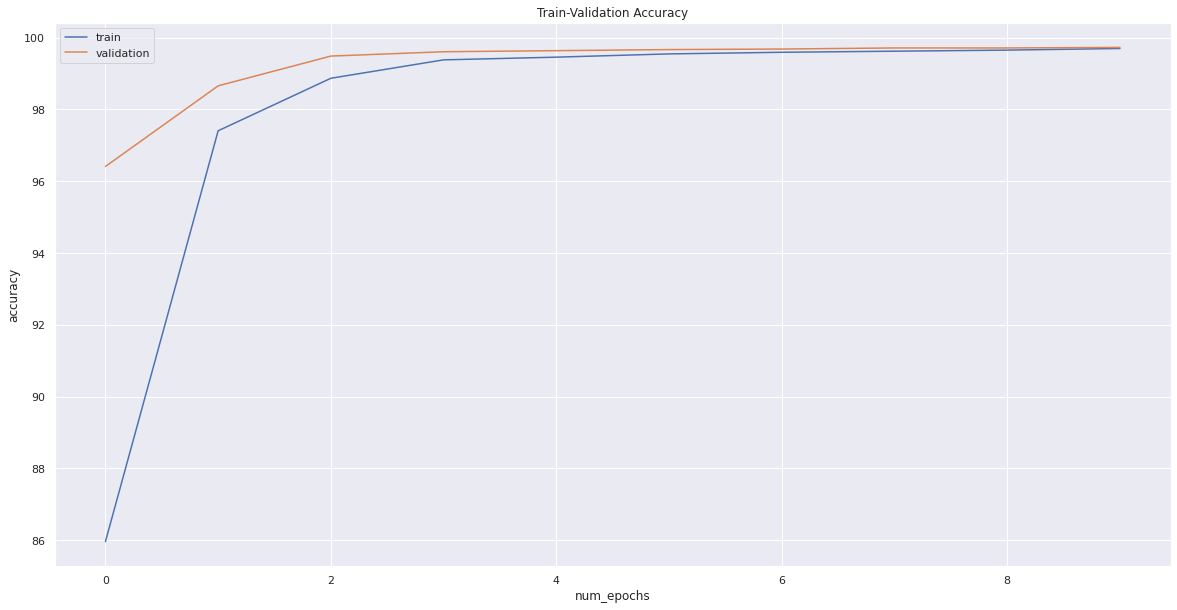

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

### STEP 6 : Grad Cam을 활용하여 예측 모델로 부터 중요한 지점 찾기

In [ ]:
! pip install pytorch-gradcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.0 MB 4.8 MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=8bdf5e71103a55619e8420270868d78305d29e12718e030b7000a19936f1c0fc
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [ ]:
# 모듈 불러오기
import os
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from PIL import Image

from torchvision.utils import make_grid

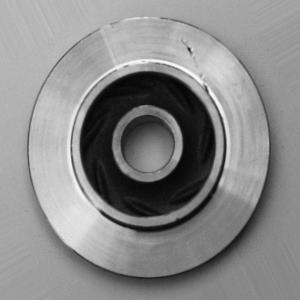

In [ ]:
# test 이미지 불러오기
img_path = os.path.join('./LG_ES_CNN_2/data/casting_data', "test/def_front/cast_def_0_7.jpeg")
pil_img = Image.open(img_path)
pil_img

In [ ]:
# test 이미지 크기 변환
torch_img = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])(pil_img).to(device)

In [ ]:
# test 이미지 정규화
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
normed_torch_img.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# 모든 layer에서 gradient 계산 가능하도록 설정
for param in model.parameters():
    param.requires_grad = True

In [ ]:
# Grad-CAM 모델 구축
# target layer는 마지막 layer로 설정함
model.eval()

target_layer = model.layer4
gradcam = GradCAM(model, target_layer)

In [ ]:
# GradCAM salinecy map 도출
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, torch_img)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


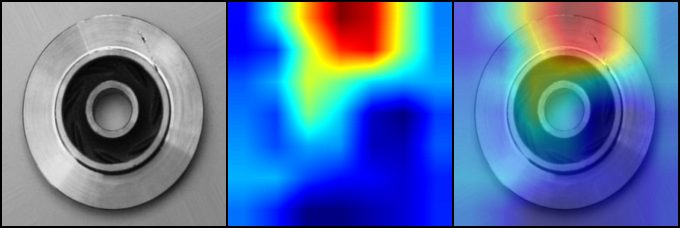

In [ ]:
# 결과 시각화
# 벌이 있는 위치의 activation이 큰 것을 통해 모델이 해당 부분을 기반으로 이미지를 'bees'로 분류했다고 해석할 수 있음
images = [torch_img.cpu(), heatmap, result]
grid_image = make_grid(images, ncol=1)

transforms.ToPILImage()(grid_image)